In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gammapy.datasets import MapDataset                                                                                                                                     
from gammapy.irf import load_cta_irfs, load_irf_dict_from_file                                                                                                                      
from gammapy.maps import MapAxis, WcsGeom, WcsNDMap                                                                                                                         
from gammapy.modeling.models import (                                                                                                                                       
    FoVBackgroundModel,                                                                                                                                                   
    SkyModel,                                                                                                                                                               
    Models,                                                                                                                                                                 
    TemplateSpatialModel,                                                                                                                                                   
)                                                                                                                                                                           
from gammapy.data import Observation, observatory_locations                                                                                                                 
from gammapy.makers import MapDatasetMaker, SafeMaskMaker                                                                                                                   
from gammapy.astro.darkmatter import profiles, JFactory, DarkMatterAnnihilationSpectralModel                                                                                
from astropy.coordinates import SkyCoord                                                                                                                                    
import astropy.units as u                                                                                                                                                   
import numpy as np                                                                                                                                                          
from joblib import Parallel, delayed                                                                                                                                        
import matplotlib.pyplot as plt       
import os

import astropy.constants as const

from titrate.utils import copy_models_to_dataset

# Validate if asymptotics are valid

quick & ugly generation of a simulation... this is just a copy of conftest.py

In [3]:
def irfs():
    path = (
        f"{os.environ.get('GAMMAPY_DATA')}"
        f"/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    )

    irfs = load_irf_dict_from_file(path)

    return irfs


def observation():
    livetime = 50 * u.hr
    pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
    location = observatory_locations["cta_south"]
    obs = Observation.create(
        pointing=pointing, livetime=livetime, irfs=irfs(), location=location
    )

    return obs


def energy_axes():
    energy_reco = MapAxis.from_edges(
        np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
    )
    energy_axis_true = MapAxis.from_energy_bounds(
        "0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true"
    )
    migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

    return {"true": energy_axis_true, "reco": energy_reco, "migra": migra_axis}


def geometry3d():
    geom = WcsGeom.create(
        skydir=observation().pointing.fixed_icrs,
        width=(4, 4),
        binsz=0.04,
        frame="galactic",
        axes=[energy_axes()["reco"]],
    )

    return geom



def geometry2d():
    geom = WcsGeom.create(
        skydir=observation().pointing.fixed_icrs,
        width=(4, 4),
        binsz=0.04,
        frame="galactic",
    )

    return geom



def ursa_major_ii_profile():
    rhos = (
        10**-1.1331 * const.M_sun.to(u.GeV, equivalencies=u.mass_energy()) / u.pc**3
    )
    rs = 10**3.6317 * u.pc

    profile = profiles.NFWProfile(r_s=rs, rho_s=rhos)
    profile.DISTANCE_GC = 32 * u.kpc

    return profile



def dm_models():
    jfactory = JFactory(
        geom=geometry2d(),
        profile=ursa_major_ii_profile(),
        distance=ursa_major_ii_profile().DISTANCE_GC,
    )
    jfactor = jfactory.compute_differential_jfactor()
    jfact_map = WcsNDMap(geom=geometry2d(), data=jfactor.value, unit=jfactor.unit)
    spatial_model = TemplateSpatialModel(jfact_map, normalize=False)

    spectral_model = DarkMatterAnnihilationSpectralModel(mass=50 * u.TeV, channel="b")

    model_simu = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name="darkmatter",
    )

    bkg_model = FoVBackgroundModel(dataset_name="foo")

    models = Models([model_simu, bkg_model])

    return models



def measurement_dataset():
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

    empty_measurement = MapDataset.create(
        geometry3d(),
        energy_axis_true=energy_axes()["true"],
        migra_axis=energy_axes()["migra"],
        name="measurement",
    )

    measurement_dataset = maker.run(empty_measurement, observation())
    measurement_dataset = maker_safe_mask.run(measurement_dataset, observation())

    copy_models_to_dataset(dm_models(), measurement_dataset)

    measurement_dataset.fake(random_state=42)

    return measurement_dataset

In [4]:
meas_dataset = measurement_dataset()

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate

In [5]:
print(meas_dataset)

MapDataset
----------

  Name                            : measurement 

  Total counts                    : 2273471 
  Total background counts         : 2272694.54
  Total excess counts             : 776.46

  Predicted counts                : 2272781.69
  Predicted background counts     : 2272694.54
  Predicted excess counts         : 87.14

  Exposure min                    : 7.04e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 90000 
  Number of fit bins              : 90000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -14027675.21

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : measurement-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal model 

In [6]:
def asimov_dataset():
    from titrate.datasets import AsimovMapDataset
    from titrate.utils import copy_models_to_dataset

    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

    empty_asimov = AsimovMapDataset.create(
        geometry3d(),
        energy_axis_true=energy_axes()["true"],
        migra_axis=energy_axes()["migra"],
        name="asimov",
    )

    asimov_dataset = maker.run(empty_asimov, observation())
    asimov_dataset = maker_safe_mask.run(asimov_dataset, observation())

    copy_models_to_dataset(dm_models(), asimov_dataset)

    asimov_dataset.fake()

    return asimov_dataset

In [7]:
asi_dataset = asimov_dataset()

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate

In [8]:
print(asi_dataset)

AsimovMapDataset
----------------

  Name                            : asimov 

  Total counts                    : 2272781 
  Total background counts         : 2272694.54
  Total excess counts             : 87.14

  Predicted counts                : 2272781.69
  Predicted background counts     : 2272694.54
  Predicted excess counts         : 87.14

  Exposure min                    : 7.04e+07 m2 s
  Exposure max                    : 9.70e+11 m2 s

  Number of total bins            : 90000 
  Number of fit bins              : 90000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -14023900.06

  Number of models                : 2 
  Number of parameters            : 4
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : asimov-darkmatter
    Datasets names            : None
    Spectral model type       : DarkMatterAnnihilationSpectralModel
    Spatial  model type       : TemplateSpatialModel
    Temporal model

# Validation

In [9]:
from titrate.validation import AsymptoticValidator

## QMuTestStatistic

In [10]:
validator = AsymptoticValidator(meas_dataset, asi_dataset, 'qmu', 'scale')

In [11]:
validator.validate(n_toys=1000)

{'pvalue_diff': 0.8306038532710767,
 'pvalue_same': 0.864685260600026,
 'valid': True}

/net/nfshome/home/sfroese/PHD/TITRATE/titrate/statistics.py:105: RuntimeWarning: divide by zero encountered in divide
  1


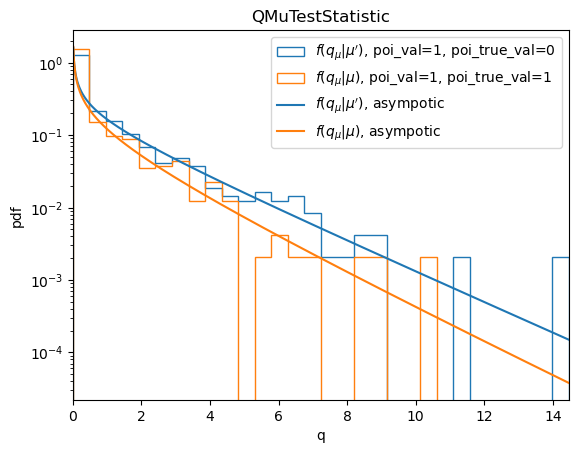

In [12]:
validator.plot_validation(n_toys=1000)

## QTildeMuTestStatistic

In [13]:
validator_tilde = AsymptoticValidator(meas_dataset, asi_dataset, 'qtildemu', 'scale')

In [14]:
validator_tilde.validate(n_toys=1000)

/scratch/sfroese/envs/titrate-dev/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'pvalue_diff': 0.9413103789420818,
 'pvalue_same': 0.3429201168560012,
 'valid': True}

/net/nfshome/home/sfroese/PHD/TITRATE/titrate/statistics.py:207: RuntimeWarning: divide by zero encountered in divide
  1


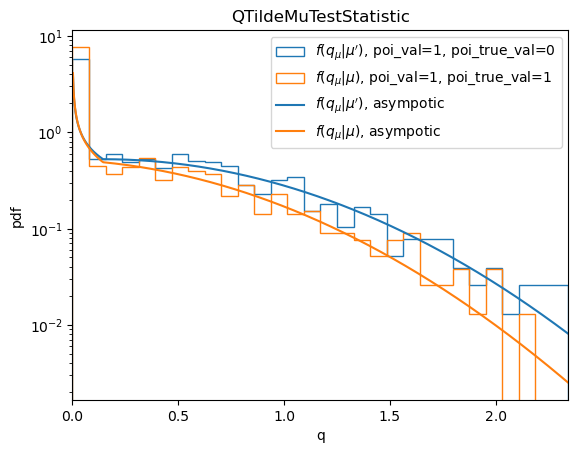

In [15]:
validator_tilde.plot_validation(n_toys=1000)

# Calculating Upper Limits

In [68]:
from titrate.upperlimits import ULCalculator

In [69]:
ulcalc = ULCalculator(meas_dataset, 'qmu', 'scale')

In [70]:
ulcalc.compute()

22.435632183120642

In [13]:
jfactory = JFactory(
    geom=geometry2d(),
    profile=ursa_major_ii_profile(),
    distance=ursa_major_ii_profile().DISTANCE_GC,
)
jfactor = jfactory.compute_differential_jfactor()
jfact_map = WcsNDMap(geom=geometry2d(), data=jfactor.value, unit=jfactor.unit)
spatial_model = TemplateSpatialModel(jfact_map, normalize=False)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/stefan/mambaforge/envs/titrate-dev/lib/python3.11/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [76]:
poi_uls = np.array([])
med_uls = np.array([])
one_sig_plus = np.array([])
one_sig_minus = np.array([])
two_sig_plus = np.array([])
two_sig_minus = np.array([])
for m in masses:
    spectral_model = DarkMatterAnnihilationSpectralModel(mass=m*u.TeV, channel='b')

    model_simu = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name="measurement-darkmatter",
    )

    bkg_model = FoVBackgroundModel(dataset_name="measurement")
    models = Models([model_simu, bkg_model])
    meas_dataset.models = models

    ulcalc = ULCalculator(meas_dataset, 'qmu', 'scale', cl_type='s+b')

    bands = ulcalc.expected_uls()
    poi_uls = np.append(poi_uls, ulcalc.compute())
    med_uls = np.append(med_uls, bands['med'])
    one_sig_minus = np.append(one_sig_minus, bands['1sig'][0])
    one_sig_plus = np.append(one_sig_plus, bands['1sig'][1])
    two_sig_minus = np.append(two_sig_minus, bands['2sig'][0])
    two_sig_plus = np.append(two_sig_plus, bands['2sig'][1])

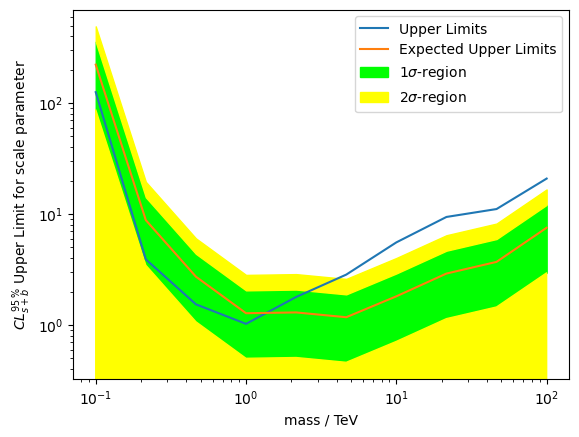

In [78]:
plt.plot(masses, poi_uls, label='Upper Limits')
plt.plot(masses, med_uls, label='Expected Upper Limits')
plt.fill_between(masses, med_uls, one_sig_plus, color='lime', label=r'$1\sigma$-region')
plt.fill_between(masses, med_uls, one_sig_minus, color='lime')
plt.fill_between(masses, one_sig_plus, two_sig_plus, color='yellow', label=r'$2\sigma$-region')
plt.fill_between(masses, one_sig_minus, two_sig_minus, color='yellow')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$CL_{s+b}^{95\,\%}$ Upper Limit for scale parameter')
plt.xlabel('mass / TeV')
plt.legend()

In [80]:
poi_uls2 = np.array([])
med_uls2 = np.array([])
one_sig_plus2 = np.array([])
one_sig_minus2 = np.array([])
two_sig_plus2 = np.array([])
two_sig_minus2 = np.array([])
for m in masses:
    spectral_model = DarkMatterAnnihilationSpectralModel(mass=m*u.TeV, channel='b')

    model_simu = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name="measurement-darkmatter",
    )

    bkg_model = FoVBackgroundModel(dataset_name="measurement")
    models = Models([model_simu, bkg_model])
    meas_dataset.models = models

    ulcalc = ULCalculator(meas_dataset, 'qmu', 'scale', cl_type='s')

    bands = ulcalc.expected_uls()
    poi_uls2 = np.append(poi_uls2, ulcalc.compute())
    med_uls2 = np.append(med_uls2, bands['med'])
    one_sig_minus2 = np.append(one_sig_minus2, bands['1sig'][0])
    one_sig_plus2 = np.append(one_sig_plus2, bands['1sig'][1])
    two_sig_minus2 = np.append(two_sig_minus2, bands['2sig'][0])
    two_sig_plus2 = np.append(two_sig_plus2, bands['2sig'][1])

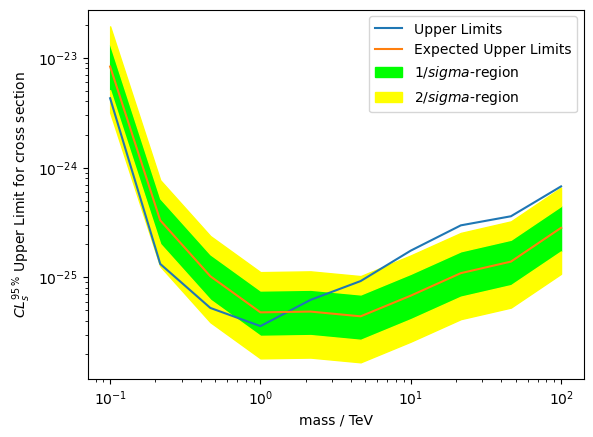

In [82]:
cs = meas_dataset.models[0].spectral_model.THERMAL_RELIC_CROSS_SECTION.value
plt.plot(masses, poi_uls2*cs, label='Upper Limits')
plt.plot(masses, med_uls2*cs, label='Expected Upper Limits')
plt.fill_between(masses, med_uls2*cs, one_sig_plus2*cs, color='lime', label=r'$1/sigma$-region')
plt.fill_between(masses, med_uls2*cs, one_sig_minus2*cs, color='lime')
plt.fill_between(masses, one_sig_plus2*cs, two_sig_plus2*cs, color='yellow', label=r'$2/sigma$-region')
plt.fill_between(masses, one_sig_minus2*cs, two_sig_minus2*cs, color='yellow')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$CL_{s}^{95\,\%}$ Upper Limit for cross section')
plt.xlabel('mass / TeV')
plt.legend()